In [1]:
def calculate_max_doppler_shift(v, fc, c=3e8):
    return (v * fc) / c

# Parameters
velocity = 10  # Relative velocity in m/s
carrier_frequency = 2.4e9  # Carrier frequency in Hz (e.g., 2.4 GHz)

# Calculate maximum Doppler shift
max_doppler_shift = calculate_max_doppler_shift(velocity, carrier_frequency)
print(f"Max Doppler Shift: {max_doppler_shift} Hz")


Max Doppler Shift: 80.0 Hz


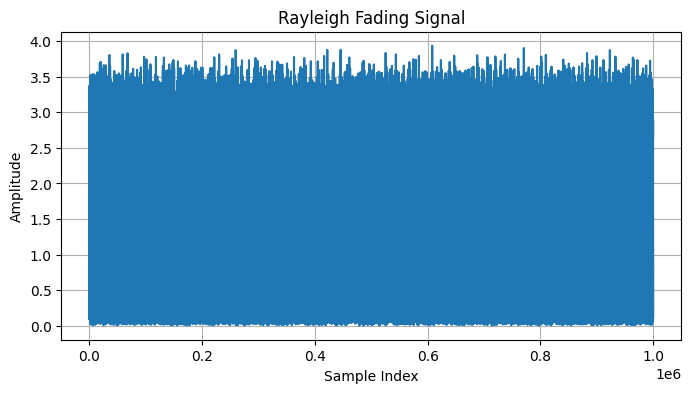

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def rayleigh_fading(num_samples, max_doppler_shift, num_sinusoids=8):
    t = np.arange(num_samples)
    f_D = max_doppler_shift

    # Random initial phases and angles
    phases = 2 * np.pi * np.random.rand(num_sinusoids)
    angles = 2 * np.pi * np.random.rand(num_sinusoids)

    # Sum-of-sinusoids method
    real_part = np.zeros(num_samples)
    imag_part = np.zeros(num_samples)

    for i in range(num_sinusoids):
        theta = 2 * np.pi * f_D * t * np.cos(angles[i]) + phases[i]
        real_part += np.cos(theta)
        imag_part += np.sin(theta)

    real_part /= np.sqrt(num_sinusoids / 2)
    imag_part /= np.sqrt(num_sinusoids / 2)


    # Rayleigh fading signal
    rayleigh_signal = np.sqrt(real_part**2 + imag_part**2)

    return rayleigh_signal

# Parameters
num_samples = 1000000

# Generate Rayleigh fading signal
rayleigh_signal = rayleigh_fading(num_samples, max_doppler_shift)

# Plot the Rayleigh fading signal
plt.figure(figsize=(8, 4))
plt.plot(rayleigh_signal)
plt.title('Rayleigh Fading Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



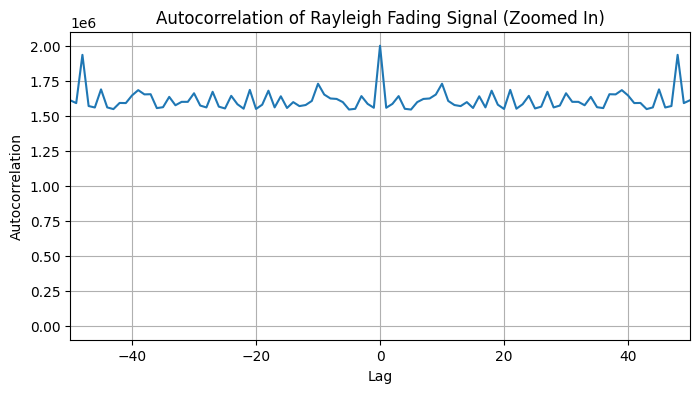

In [3]:
from scipy.signal import correlate

# Calculate and plot the autocorrelation of the Rayleigh fading signal
autocorrelation = correlate(rayleigh_signal, rayleigh_signal, mode='full')
lags = np.arange(-num_samples + 1, num_samples)

# Define the range around the center to zoom into
center_range = 50  # Adjust this value to control how much you zoom in

plt.figure(figsize=(8, 4))
plt.plot(lags, autocorrelation)
plt.title('Autocorrelation of Rayleigh Fading Signal (Zoomed In)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xlim(-center_range, center_range)
plt.grid(True)
plt.show()

In [4]:
# Generate input vector X with random values of -1 and 1
X = np.random.choice([-1, 1], size=num_samples)

print(X)


[-1  1 -1 ...  1 -1 -1]


In [5]:
import numpy as np

# Function to calculate the power of a signal
def calculate_power(signal):
    return np.mean(signal ** 2)

# Desired SNR in dB
desired_snr_db = 10  # Adjust this value to set the SNR level

# Calculate signal power
signal_power = calculate_power(rayleigh_signal)  # here I am calculating signal to noise ratio of the rayleigh signal is it correct?  // check once

# Convert SNR from dB to linear scale
desired_snr_linear = 10 ** (desired_snr_db / 10)

# Calculate noise power based on desired SNR
noise_power = signal_power / desired_snr_linear

# Generate noise with the calculated noise power
noise = np.random.normal(0, np.sqrt(noise_power), num_samples)

# Generate output vector Y using the equation y = hx + noise
Y = rayleigh_signal * X + noise

In [6]:
# Define packet size
packet_size = 1000
num_packets = len(Y) // packet_size

# Divide into known and unknown packets
known_packets = X[:packet_size]  # Use the first packet as known
unknown_packets = X[packet_size:]  # Rest as unknown

Y_knownPackets=Y[:packet_size]

In [7]:
from scipy.linalg import lstsq

# Initial estimation of h for the first packet
X_packet = X[:packet_size]
Y_packet = Y[:packet_size]
h_initial, _, _, _ = lstsq(X_packet[:, np.newaxis], Y_packet)

print(f"Initial estimated h: {h_initial[0]}")

Initial estimated h: 1.3222392332394255


In [ ]:
# Initial estimation of h for the first packet
X_packet = X[:packet_size]
Y_packet = Y[:packet_size]
h_initial, _, _, _ = lstsq(X_packet[:, np.newaxis], Y_packet)

print(f"Initial estimated h: {h_initial[0]}")

# Prepare the data for LSTM
H_input = np.array([h_initial[0]])

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Function to scale and reshape data for LSTM
def prepare_lstm_data(H_input):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    H_input_scaled = scaler.fit_transform(H_input.reshape(-1, 1))
    H_input_scaled = H_input_scaled.reshape((H_input_scaled.shape[0], 1, 1))
    return H_input_scaled, scaler

# Iterate over the packets to predict h
for i in range(1, num_packets):
    start_idx = i * packet_size
    end_idx = start_idx + packet_size
    X_packet = X[start_idx:end_idx]
    Y_packet = Y[start_idx:end_idx]

    # Train the LSTM model with the known data (previous H_input)
    H_input_scaled, scaler = prepare_lstm_data(H_input)
    model.fit(H_input_scaled, H_input_scaled, epochs=300, verbose=0)

    # Predict the next h value
    H_next_scaled = model.predict(H_input_scaled[-1].reshape((1, 1, 1)))
    H_next = scaler.inverse_transform(H_next_scaled)

    # Add the new estimated h to the input data
    H_input = np.append(H_input, H_next[0][0])

    print(f"Packet {i}: Predicted h: {H_next[0][0]}")

print("Final estimated h values:", H_input)

Initial estimated h: 1.3222392332394255


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Packet 1: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 2: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 3: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Packet 4: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 5: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Packet 6: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 7: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Packet 8: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Packet 9: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Packet 10: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Packet 11: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 12: Predicted h: 1.3221923112869263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


# Prepare the data for LSTM
H_input = np.array([h_initial[0]])
H_output = np.array([h_initial[0]])

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Function to scale and reshape data for LSTM
def prepare_lstm_data(H_input):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    H_input_scaled = scaler.fit_transform(H_input.reshape(-1, 1))
    H_input_scaled = H_input_scaled.reshape((H_input_scaled.shape[0], 1, 1))
    return H_input_scaled, scaler

# Iterate over the packets to predict h
for i in range(1, num_packets):
    start_idx = i * packet_size
    end_idx = start_idx + packet_size
    X_packet = X[start_idx:end_idx]
    Y_packet = Y[start_idx:end_idx]

    # Train the LSTM model with the known data
    if H_output.size > 0:
        H_input_scaled, scaler = prepare_lstm_data(H_input)
        H_output_scaled = scaler.transform(H_output.reshape(-1, 1))
        model.fit(H_input_scaled, H_output_scaled , epochs=300, verbose=0)

    # Predict the next h value
    H_input_scaled, scaler = prepare_lstm_data(H_input)
    H_next_scaled = model.predict(H_input_scaled[-1].reshape((1, 1, 1)))
    H_next = scaler.inverse_transform(H_next_scaled)

    # Add the new estimated h to the input data
    H_input = np.append(H_input, H_next[0][0])

    # Estimate h for the current packet using LMS
    h_current, _, _, _ = lstsq(X_packet[:, np.newaxis], Y_packet)
    H_output = np.append(H_output, h_current[0])

    print(f"Packet {i}: Predicted h: {H_next[0][0]}, LMS estimated h: {h_current[0]}")

print("Final estimated h values:", H_input)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Packet 1: Predicted h: 1.322199821472168, LMS estimated h: 1.3083453572128645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 2: Predicted h: 1.321712613105774, LMS estimated h: 1.1862031702136588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 3: Predicted h: 1.3080837726593018, LMS estimated h: 1.2277966052870295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 4: Predicted h: 0.9516860246658325, LMS estimated h: 1.3179523473165344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 5: Predicted h: -7.824188709259033, LMS estimated h: 1.2813736570816723
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Packet 6: Predicted h: -212.08091735839844, LMS estimated h: 1.2145382613661562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 7: Predicted h: -4714.138671875, LMS estimated h: 1.3044689387467967
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 8: Predicted h: -98787.328125, LMS estimated h: 1.2952537139799032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Packet 9: Predicted h: -1963331.87

KeyboardInterrupt: 

In [ ]:

import torch
from torch import nn
from d2l import torch as d2l


In [ ]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

In [ ]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


In [ ]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)


In [ ]:
#read data:
# get the size of the full data set i.e the time given in one column and value to be predicted in the other

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df.head(),df.tail()

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

from keras.preprocessing.sequence import TimeseriesGenerator


In [ ]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

X.shape


# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(generator,epochs=50)

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:

last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)
scaled_test[0]

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)